# Solar RL Agent

Softmax Actor-Critic for continuous task of positioning solar array to maximize energy

### Imports & Constants

In [1]:
import serial
import time
import random
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tqdm
from tqdm import tqdm

In [2]:
# Declare random seed
RANDOM_SEED = 1
random.seed(RANDOM_SEED)

# Set default constants for problem
ARRAY_DIMENSION_TUPLE = (37,37)
MOTOR_ANGLE_POWER_DRAW = 0.0001

In [3]:
# Placeholder environment, hyper-parameter study imports
import solar_env
from solar_env import SolarEnv
import visualizations

### Helper Functions

#### Non-Agent Related

In [4]:
def rolling_avg_calc(value, last_value, window):
    return (1/window)*value + (1-(1/window))*last_value

#### Agent Related

Converting index, motor positions

In [5]:
def convert_motor_positions_to_2d_index(position_tuple):
    # position tuple is (m1 position, m2 position)
    return (int(position_tuple[0]//5), int(position_tuple[1]//5))

def convert_2d_index_to_motor_positions(index_tuple):
    return (index_tuple[0]*5, index_tuple[1]*5)

def convert_1d_index_to_2d_index(index, dimensions=ARRAY_DIMENSION_TUPLE):
    return np.unravel_index(index, dimensions)

def convert_2d_index_to_1d_index(index_tuple, dimensions=ARRAY_DIMENSION_TUPLE):
    return np.ravel_multi_index(index_tuple, dimensions)

def convert_motor_positions_to_1d_index(position_tuple, dimensions=ARRAY_DIMENSION_TUPLE):
    return convert_2d_index_to_1d_index(convert_motor_positions_to_2d_index(position_tuple), dimensions)

def convert_1d_index_to_motor_positions(index, dimensions=ARRAY_DIMENSION_TUPLE):
    return convert_2d_index_to_motor_positions(convert_1d_index_to_2d_index(index, dimensions))

Policy

In [6]:
def softmax_prob(actor_av_array, temperature=1):
    # Divide all values by temperature
    temperature_array = actor_av_array/temperature
    
    # Find max state value
    max_value = np.max(temperature_array)
    
    # Generate the numerator for each element by subtracting max value and exponentiating
    numerator_array = temperature_array - max_value
    numerator_array = np.exp(numerator_array)

    # Get the denominator by summing all values in the numerator
    denominator_array = np.sum(numerator_array)
    
    
    # Calculate the softmax value array and return to agent
    softmax_array = numerator_array / denominator_array
    
    return softmax_array

## Agent Class

In [7]:
class SoftmaxAgent:
    def __init__(self, actor_step_size, critic_step_size, avg_reward_step_size, temperature_value, env_shape, reward_rolling_avg_window, 
                 random_seed=RANDOM_SEED, actor_init_value=None, critic_init_value=None):
        # Set step sizes
        self.actor_step_size = actor_step_size
        self.critic_step_size = critic_step_size
        self.avg_reward_step_size = avg_reward_step_size
        self.temperature = temperature_value
        
        # Set up memory for the actor and critic
        self.env_shape = env_shape
        max_index_2d = self.env_shape[0] - 1
        max_index_1d = convert_2d_index_to_1d_index((max_index_2d, max_index_2d), dimensions=self.env_shape)
        self.agent_shape = (max_index_1d + 1, max_index_1d + 1)
        
        # Set init values of actor and critic
        # Actor
        if actor_init_value:
            self.actor_array = np.full(self.agent_shape, actor_init_value)
        else:
            self.actor_array = np.zeros(self.agent_shape)
        # Critic
        if critic_init_value:
            self.critic_array = np.full(self.agent_shape, critic_init_value)
        else:
            self.critic_array = np.zeros(self.agent_shape)
        
        # Create the actions and feature vectors
        self.actions_vector = np.array(range(0, max_index_1d + 1))
        self.base_feature_vector = np.zeros(max_index_1d + 1)
        
        # Set up fields for agent steps -- all agent internal functions are 1d index
        self.random_generator = np.random.RandomState(random_seed) 
        self.last_state = None
        self.last_action = None
        self.state = None
        self.last_reward = None
        self.avg_reward = 0
        self.step_softmax_prob = None
    
        # Set up tracking metric items
        self.state_visits = np.zeros(self.env_shape) # track in 2d to better map to env map
        self.total_reward = 0
        self.rolling_reward = 0
        self.rolling_window = reward_rolling_avg_window
        self.transition_dict = None
        self.last_delta = 0
    
    # Agent Operation
    # =============================================
    def agent_start(self):
        # Initialize the agent
        self.avg_reward = 0
        self.last_state = self.agent_shape[0]//2  # Set to the middle state for init
        self.last_action = self.last_state
        self.last_reward = 0
        
        # For tracking
        self.state_visits[convert_1d_index_to_2d_index(self.last_state, dimensions=self.env_shape)] += 1
    
    
    def agent_policy(self):
        # Compute the softmax prob for actions in given state
        softmax_prob_array = softmax_prob(self.actor_array[self.last_state], self.temperature)
        
        # Overlay the softmax probs onto actions vector
        chosen_action = self.random_generator.choice(self.actions_vector, p=softmax_prob_array)
        
        # save softmax_prob as it will be useful later when updating the Actor
        self.step_softmax_prob = softmax_prob_array.copy()
        self.last_action = chosen_action
        
        # Return the 1d index of action
        return chosen_action
        
    
    def agent_step(self, reward, next_state):
        # Compute delta
        delta = reward - self.avg_reward + np.mean(self.critic_array[next_state]) - np.mean(self.critic_array[self.last_state])
        
        # Update avg reward
        self.avg_reward += self.avg_reward_step_size * delta
        
        # Update critic weights
        self.critic_array[self.last_state][self.last_action] += self.critic_step_size * delta
        
        # Update actor weights
        feature_vector = self.base_feature_vector.copy() # copy the zeros vector
        feature_vector[self.last_action] = 1 # set last action to one
        self.actor_array[self.last_state] += self.actor_step_size * delta * (feature_vector - self.step_softmax_prob)
        
        # Update last state, etc
        self.last_state = next_state
        
        # For tracking
        self.total_reward += reward
        self.rolling_reward = rolling_avg_calc(reward, self.rolling_reward, self.rolling_window)
        self.state_visits[convert_1d_index_to_2d_index(self.last_state, self.env_shape)] += 1
        self.last_delta = delta
    
    # Tracking
    # =============================================
    
    def get_critic_array(self):
        return self.critic_array.copy()
    
    def get_actor_array(self):
        return self.actor_array.copy()
    
    def set_actor_array(self, array):
        self.actor_array = array
        
    def get_actions_vector(self):
        return self.actions_vector
    
    def get_agent_avg_reward(self):
        return self.avg_reward
    
    def get_agent_last_delta(self):
        return self.last_delta
    
    def get_agent_last_state(self):
        return self.last_state
    
    def get_base_feature_vector(self):
        return self.base_feature_vector
    
    def get_agent_total_reward(self):
        return self.total_reward
    
    def get_agent_rolling_reward(self):
        return self.rolling_reward
    
    def get_state_visits(self):
        return self.state_visits.copy()

## Environment Set Up

In [8]:
# Set environment path
experiment_data_path = 'simulation_data/data/initial_environments/room_light_scan_3_23_22.csv'

In [51]:
# Load in and format data, convert to array for environment
data_df = solar_env.load_and_format_solar_df(experiment_data_path)
env_reward_array = solar_env.convert_solar_df_to_value_array(data_df, 5)
env_reward_array = env_reward_array[10:25,10:25]

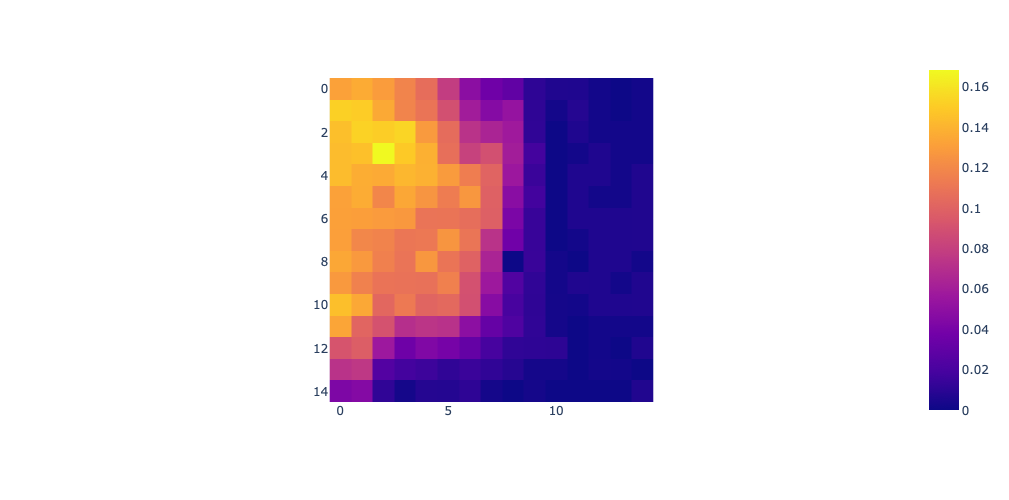

In [52]:
# Visualize the environment to validate
visualizations.heatmap(env_reward_array, show_values=False, width=500, height=500)

## Experiment Setup

### Experiment Runtime Functions

In [53]:
# Run individual step of experiment
def run_experiment_step(env:SolarEnv, agent:SoftmaxAgent, step):
    """
    Carry out one step of interaction between agent and environment
    
    Args:
        env (SolarEnv): the environment being used in the experiment
        agent (SoftmaxAgent): the agent being used in the experiment
        step (int): the step number of the experiment
    Returns:
        None
    """
    
    action = agent.agent_policy()
    reward, next_state_tuple = env.env_step(convert_1d_index_to_2d_index(action, env.get_env_shape()), 
                                            convert_1d_index_to_2d_index(agent.get_agent_last_state(), env.get_env_shape()))
    agent.agent_step(reward, convert_2d_index_to_1d_index(next_state_tuple, env.get_env_shape()))

In [54]:
def create_tracking_dict(step, env:SolarEnv, agent:SoftmaxAgent):
    """
    Generate a tracking dict for a given step of an experiment
    
    Args:
        step (int): the step number of an experiment
        env (SolarEnv): the environment of an experiment
        agent (SoftmaxAgent): the agent of an experiment
    Returns:
        dict: a tracking dict with keys seen in function below
    """
    
    tracking_dict = {
        'step': step,
        'delta': agent.get_agent_last_delta(),
        'state_value': agent.get_critic_array(),
        'action_prob': agent.get_actor_array(),
        'rolling_power': agent.get_agent_rolling_reward(),
        'state_visits': agent.get_state_visits(),
        'total_energy': agent.get_agent_total_reward(),
        'env_rewards': env.get_reward_array()
    }
    return tracking_dict

In [55]:
def run_agent_experiment(environment:SolarEnv, steps, seed, actor_step_size, critic_step_size, 
                         avg_reward_step_size, temperature, rolling_steps_measurement=10, 
                         logging_interval=1000, hide_progress_bar=False):
    """
    Run an end-to-end experiment with the agent and determine the total reward during the experiment
    
    Args:
        environment (SolarEnv): The environment class for the agent to interact with
        steps (int): The number of steps to run the experiment for
        seed (int): The random seed number to use for the agent
        actor_step_size (float): Step-size parameter for actor in agent
        critic_step_size (float): Step-size parameter for critic in agent
        avg_reward_step_size (float): Step-size parameter for avg reward in agent
        temperature (float): Temperature parameter for actor policy
    Kwargs:
        rolling_steps_measurement (int): For tracking, the rolling avg steps for calculating running power from agent
        logging_interval (int): Frequency of steps to log metrics from experiment, None to avoid logging
        hide_progress_bar (bool): Set to True to hide the tqdm bar
    Returns:
        float, DataFrame: the total reward the agent achieved in experiment, the tracking df of results in steps
    """
    
    # Create agent with properties
    experiment_agent = SoftmaxAgent(actor_step_size=actor_step_size, critic_step_size=critic_step_size,
                                avg_reward_step_size=avg_reward_step_size,
                                temperature_value=temperature, env_shape=environment.get_env_shape(), 
                                reward_rolling_avg_window=rolling_steps_measurement, random_seed=seed)
    # Initialize Agent
    experiment_agent.agent_start()
    
    # Initialize a tradcking dict
    tracking_dict_list = []
    tracking_dict_list.append(create_tracking_dict(step=0, env=environment, agent=experiment_agent))
    
    # Only do one conditional logging check to improve runtime
    if logging_interval is not None:
        # Run specified number of steps
        for i in tqdm(range(1, steps + 1), disable=hide_progress_bar):
            run_experiment_step(environment, experiment_agent, step=i)
            if i % logging_interval == 0:
                tracking_dict_list.append(create_tracking_dict(step=i, env=environment, agent=experiment_agent))
        tracking_df = pd.DataFrame(tracking_dict_list)
    
    # If no logging, just run the experiment straight
    else:
        for i in tqdm(range(1, steps + 1), disable=hide_progress_bar):
            run_experiment_step(environment, experiment_agent, step=i)
        tracking_df = pd.DataFrame() # empty df
    
    # Return total reward from experiment
    return experiment_agent.get_agent_total_reward(), tracking_df

### Hyperparameter Study Functions

In [56]:
def run_hyperparam_study(environment:SolarEnv, steps, seed, 
                         temperature_values=[1*10**-x for x in range(0,5)], 
                         actor_step_size_values=[1*10**-x for x in range(0,5)], 
                         critic_step_size_values=[1*10**-x for x in range(0,5)], 
                         avg_reward_step_size_values=[1*10**-x for x in range(0,5)]):
    """
    Conduct a hyperparameter study
    
    Args:
        environment (SolarEnv): the environment to use for the study
        steps (int): the number of steps to run each set of hyperparameters for in an experiment
        seed (int): the random seed number to use for agent policy
    Kwargs:
        temperature_values (list): A list of values to study for temperature
        actor_step_size_values: A list of values to study for actor step size
        critic_step_size_values: A list of values to study for critic step size
        avg_reward_step_size_values: A list of values to study for avg reward step size
    Returns:
        DataFrame: A dataframe of hyperparameters and the reward they achieved in an experiment
    """
    
    # Create a dict list to hold all unique combinations of hyperparameters
    combinations_dict_list = []
    # Sweep temperature
    for temperature in temperature_values:
        # Sweep actor step size
        for actor_step_size in actor_step_size_values:
            # Sweep critic step size
            for critic_step_size in critic_step_size_values:
                # Sweep avg reward step size
                for avg_reward_step_size in avg_reward_step_size_values:
                    combinations_dict_list.append(
                        {'temperature': temperature,
                         'actor_step_size': actor_step_size,
                         'critic_step_size': critic_step_size,
                         'avg_reward_step_size': avg_reward_step_size
                        }
                    )
    # Create another dict list to hold results
    results_dict_list = []
    for combination in tqdm(combinations_dict_list):
        total_reward, _ = run_agent_experiment(environment, steps, seed, **combination, hide_progress_bar=True)
        combination['total_reward'] = total_reward
        results_dict_list.append(combination)
    # Return a DataFrame of all the results
    return pd.DataFrame(results_dict_list)

## Run Experiment

### Environment and Agent Creation

In [57]:
# Set environment settings
env_roll_frequency = 1000
# Create environment
exp_env = SolarEnv(env_reward_array, roll_frequency=env_roll_frequency)

In [58]:
# Run a hyperparameter study
study_df = run_hyperparam_study(exp_env, steps=10000, seed=RANDOM_SEED)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [03:41<00:00,  2.82it/s]


In [59]:
study_df.sort_values(by='total_reward', ascending=False)

,temperature,actor_step_size,critic_step_size,avg_reward_step_size,total_reward
384,0.0010,1.00,0.1000,0.0001,1088.882114
534,0.0001,0.10,0.1000,0.0001,1088.882114
262,0.0100,1.00,0.0100,0.0100,914.665799
562,0.0001,0.01,0.0100,0.0100,914.665799
412,0.0010,0.10,0.0100,0.0100,914.665799
...,...,...,...,...,...
545,0.0001,0.10,0.0001,1.0000,325.598928
395,0.0010,1.00,0.0001,1.0000,325.598928
514,0.0001,1.00,0.0100,0.0001,277.515437
515,0.0001,1.00,0.0010,1.0000,119.155156


In [60]:
# Set agent settings
exp_actor_step_size = 1
exp_critic_step_size = 0.1
exp_avg_reward_step_size = 0.0001
exp_temperature_value = 0.001
exp_env_shape = exp_env.get_env_shape()
exp_reward_rolling_avg_window = 10
exp_random_seed = RANDOM_SEED
# Create agent
# exp_agent = SoftmaxAgent(exp_actor_step_size, exp_critic_step_size, exp_avg_reward_step_size, 
#                          exp_temperature_value, exp_env_shape, exp_reward_rolling_avg_window,
#                          random_seed=exp_random_seed)

In [61]:
# Set experiment parameters
exp_steps = 100000
exp_logging_interval = 1000

In [62]:
# Run an experiment
total_reward, tracking_df = run_agent_experiment(exp_env, steps=exp_steps, seed=exp_random_seed, 
                     actor_step_size=exp_actor_step_size, critic_step_size=exp_critic_step_size, 
                     avg_reward_step_size=exp_avg_reward_step_size, temperature=exp_temperature_value, 
                     rolling_steps_measurement=exp_reward_rolling_avg_window, logging_interval=exp_logging_interval)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 26941.83it/s]


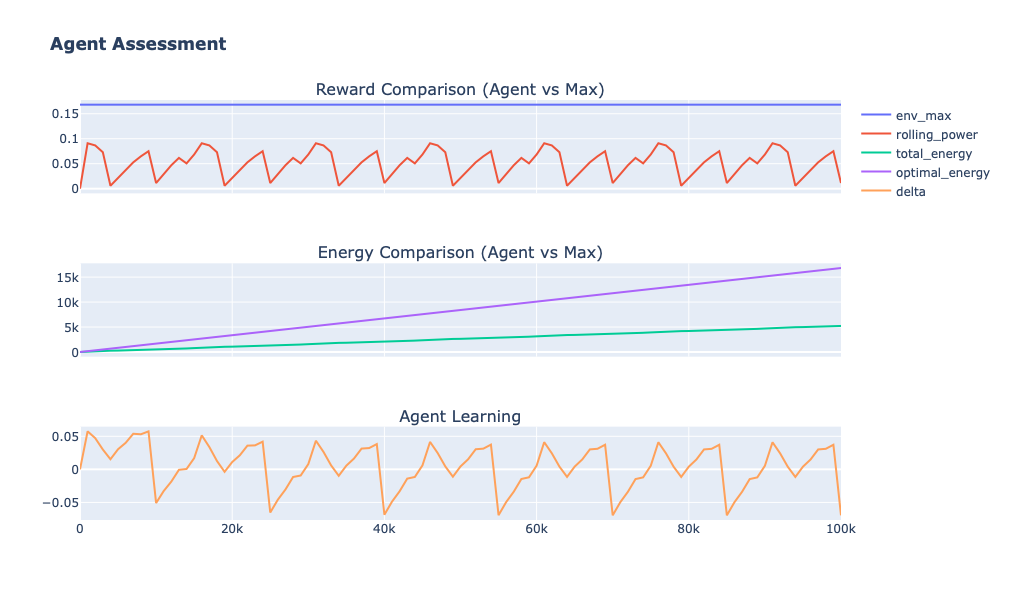

In [63]:
visualizations.plot_rolling_power(tracking_df, exp_env, height=600, width=800)

Arrays tracked are

* 'state_value'
* 'action_prob'
* 'state_visits'
* 'env_rewards'

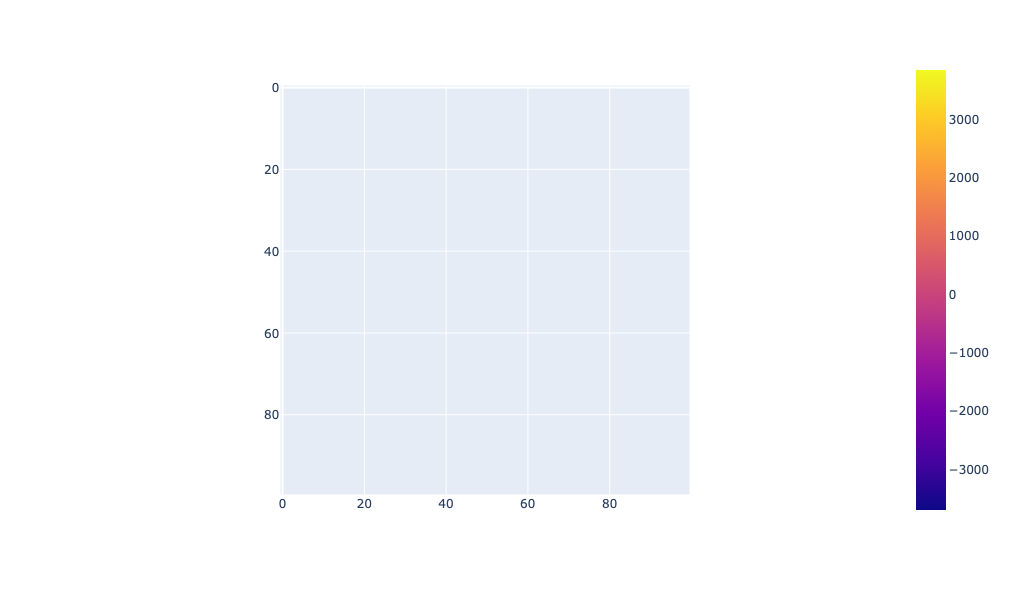

In [92]:
visualizations.heatmap(tracking_df['state_value'].iloc[-1], show_values=True)

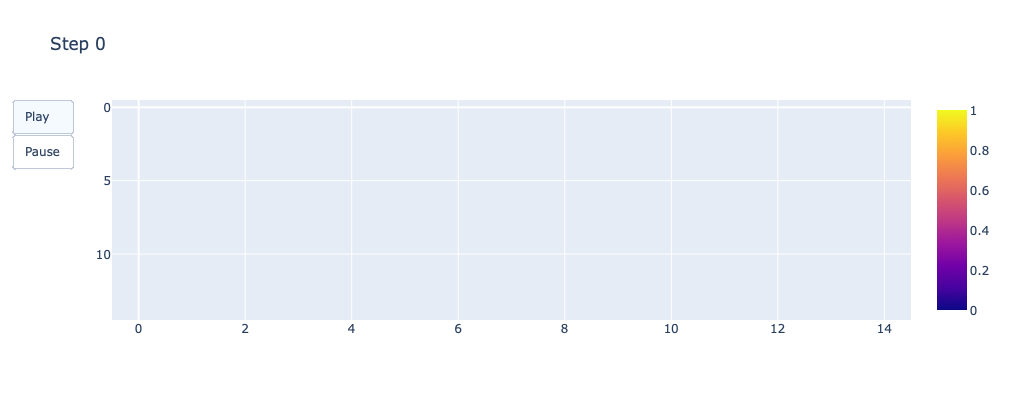

In [64]:
visualizations.plot_array_evolution(tracking_df['state_visits'].to_list(), step_interval=exp_logging_interval)